Hi Nic,

Conceptually, my statement comes from assuming the 'big blue bump' continuum comes from a simple multi-color disk model. So, for a standard temperature profile, you just multiply the appropriate blackbodies by the area of the appropriate annulus, add them up, and get an 'emergent spectrum'. Of course there's lots of additional complications but it gives you a good guide to what disk radii are generating what flux. 

The orbital/dynamical/free-fall timescale is just $(\Omega)^{-1}$, where $\Omega$ is the Keplerian frequency at that orbit; the thermal timescale is $(\alpha \times \Omega)^{-1}$, where $\alpha$ is the 'viscosity' or technically the alpha parameter of a Shakura-Sunyaev disk; the viscous timescale is $(\alpha \times \Omega)^{-1} (H/r)^{-2}$, where $(H/r)$ is the disk aspect ratio.

Hope that helps for now!


To elaborate slightly, if you have a look at Sirko & Goodman 2003, they have a semi-realistic accretion disk model (they have to artificially set a floor on Toomre's $Q$ to keep parts of the disk from fragmenting, the argument being that we see the disks don't generally fragment so... something must be keeping $Q>1$). Their temperature profile is mass and accretion rate dependent, but analytic and proportional to $r^{-3/4}$. 

I also am attaching a python program I wrote to visualize the impact of various perturbations to the disk on the emergent continuum. It should just run in python with the defaults and spit out a plot of a few different emergent continua (in both .eps and .png files with the plot). 

If you want to change parameters, they are all set by editing the program--physical inputs and display inputs are commented (and appear between e.g. PHYSICAL INPUTS and END PHYSICAL INPUTS). Basically you can make a gap in the disk that emits zero flux, due to a presumed secondary, lower mass BH, and/or you can magically depress the flux interior to the gap by some fraction. It's quasi-realistic, but gives you a visual feel for how much you have to contort the disk to get substantial flux changes at particular wavelengths (and that's the basis for my prior email statements).

In [2]:
#! /usr/bin/env python
# mcd_gap_v1.py

## Plot spectrum of multi-color disk as function of wavelength; allow for gap
##   ---Plot multiple spectra with gaps for different mass,
##   ---semi-major axis of secondary
##   ---artificially depress flux interior to gap

In [3]:
from pylab import *

import sys, os, time, string, math, subprocess
import numpy as np
import matplotlib.pyplot as plt

In [4]:
## SI units
Msun=1.99e30 #kg per solar mass
Rsun=6.95e8 #meters per solar radius
G=6.67e-11
c=3e8
sigma_SB=5.67e-8 #stefan-boltzmann const
yr=3.15e7 #seconds per year
pc=3.086e16 #meters per parsec
AU=1.496e11 #meters per AU
h=6.626e-34 #planck const
kB=1.38e-23 #boltzmann const
m_p=1.67e-27 #mass of proton
sigma_T=6.65e-29 #Thomson xsec
PI=3.1415926

$B_{\lambda }(\lambda ,T)={\frac {2hc^{2}}{\lambda ^{5}}}{\frac {1}{e^{\frac {hc}{\lambda k_{\mathrm {B} }T}}-1}}$

In [5]:
def find_B_lambda(Temp, lam):
    ## Planck function
    ## BB intensity=2hc^2/lam^5 * 1/(exp(hc/lamkT)-1)
    I=(2*h*c**2/pow(lam,5))/(exp(h*c/(lam*kB*Temp))-1)

    return I

$\sigma T{^4} =\frac{3}{8\pi} \dot{M} \Omega{^2}$

In [6]:
def find_Temp(epsilon,M_SMBH,dotm_edd,radius):

    ## find temp as a fn of radius
    ## assume sigma_SB T^4=(3/8pi) dotM Omega^2
    ## use Omega=sqrt(GM/r^3); 
    ## put r in units r_g; 
    ## dotM in units dotM_edd
    ## From Sirko & Goodman 2003
    
    prefactor=pow(((3.0/2.0)*(c**5)*m_p/(epsilon*G*M_SMBH*Msun*sigma_T*sigma_SB)), 0.25)
    T=prefactor*pow(dotm_edd, 0.25)*pow(radius,-0.75)

    return T



In [8]:
def find_area(r1,r2,r_g):
    #find area of annulus
    #2pi R deltaR
    area=2*PI*r1*r_g*(r2*r_g-r1*r_g)

    return area


In [9]:
def find_gap(a_2nd,M_2nd,M_SMBH):
    #assume width is 2R_Hill

    q=M_2nd/M_SMBH
    R_Hill=a_2nd*pow((q/3.0),(1.0/3.0))
    
    gap_r_in=a_2nd-R_Hill
    gap_r_out=a_2nd+R_Hill

    return gap_r_in,gap_r_out

In [10]:
if __name__ == "__main__":
    #F_lam=sum over all blackbodies, assuming T(r), annuli of area=2piRdeltaR
    #integrating over solid angle=pi
    #BB intensity=2hc^2/lam^5 * 1/(exp(hc/lamkT)-1)
    #log_lam, lam=wavelength range of interest
    
    #PHYSICAL INPUTS:
    #M_SMBH=mass of supermassive black hole in units of solar masses
    #controls temperature profile
    M_SMBH=3.0e8
    #compute r_g for SMBH:
    r_g_SMBH=G*M_SMBH*Msun/c**2
    #epsilon=radiative efficiency, depends on spin of SMBH, assume 0.1
    epsilon=0.1
    #dotm_edd=accretion rate in units of Eddington accretion
    dotm_edd=0.032
    #inner and outer disk radii in units of r_g of SMBH
    #(inner radius depends on spin, connect to epsilon later)
    radius_in=6.0
    radius_out=1.0e4
    #a_2nd=semi-major axis/radius of orbit of secondary around SMBH
    #units of r_g of SMBH
    #a_2nd=[60.0, 2.0e2, 1.0e3]
    a_color_cycle=['r','g','b']
    a_2nd=[150.0]
    #M_2nd=mass of secondary in solar masses
    M_2nd=[1.0e2,3.0e1,1.0e1]
    #M_2nd=[4.0e6]
    #What fraction of flux, compared to a standard disk, is left interior to the gap?
    f_depress=0.01
    #END PHYSICAL INPUTS


In [14]:
    #DISPLAY INPUTS: divide display box for graphs
    #params for axes
    #format=left, bottom, width, height
    rect1=0.1,0.1,0.75,0.75
    
    #make figure
    fig1=plt.figure(1)
    #add axes & label them
    ax1=fig1.add_axes(rect1)
    ax1.set_ylabel(r"$log \ (\lambda F_{\lambda} (arb \ units))$")
    ax1.set_xlabel(r"$log \ (\lambda (m))$")
    #Title is manual--FIX!!!
    ax1.set_title('$Thermal \ Continuum; \ q=0.04, \ 0.01, \ 0.001$')

    #set up range for x-axis
    #If want 100nm-10um:
    log_lam=np.arange(-8.0, -6.0, 0.01)
    #If want x-ray to submm:
    #log_lam=np.arange(-9.0, -4.0, 0.01)
    lam=pow(10,log_lam)
    #range for y-axis
    plt.ylim(36.0,38.0)
    #END DISPLAY INPUTS
    


(36.0, 38.0)

In [12]:
    #set up y-axis variables
    #divvy up disk radii
    log_radius=np.arange(log10(radius_in),log10(radius_out),0.01)
    radius=pow(10,log_radius)
    #make an iterable for multiple 2nd masses & loop
    flux_iter_M=[]
    for k in range(len(M_2nd)):
        #make an iterable for multiple 2nd semi-major axes & loop
        flux_iter_a=[]
        for j in range(len(a_2nd)):
            #initialize final spectrum arrays
            F_lam_tot=np.zeros(len(lam))
            F_lam_resid=np.zeros(len(lam))
            #find width of gap or proto-gap
            gap_r_in,gap_r_out=find_gap(a_2nd[j],M_2nd[k],M_SMBH)
            #compute temp, area, emitted spectrum at each radius; then sum
            for i in range((len(radius)-1)):
                Temp=find_Temp(epsilon,M_SMBH,dotm_edd,radius[i])
                B_lambda=find_B_lambda(Temp, lam)
                Area=find_area(radius[i],radius[i+1],r_g_SMBH)
                #flux is pi*A*B_lambda per annulus, pi from integrating over solid angle
                F_lam_ann=PI*Area*B_lambda
                #if ((radius[i] < gap_r_in) or (radius[i] > gap_r_out)):
                if (radius[i] > gap_r_out):
                    #only add to total if outside gap
                    F_lam_tot=F_lam_tot+F_lam_ann
                elif (radius[i] < gap_r_in):
                    #if interior to gap, cut flux
                    F_lam_tot=F_lam_tot+f_depress*F_lam_ann
                    #add missing frac to resid to recover unperturbed spec
                    F_lam_resid=F_lam_resid+(1-f_depress)*F_lam_ann
                else:
                    #otherwise add to residual, so we can reconstruct unperturbed disk
                    F_lam_resid=F_lam_resid+F_lam_ann
            #take log of total spectrum for plotting, dump to iterables for plotting
            log_F_lam=log10(F_lam_tot)
            log_lam_F_lam=log10(F_lam_tot*lam)
            F_lam_all=F_lam_tot+F_lam_resid
            log_lam_F_lam_all=log10(F_lam_all*lam)
            flux_iter_a.append(log_lam_F_lam)
        flux_iter_M.append(flux_iter_a)


/Users/npr1/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp


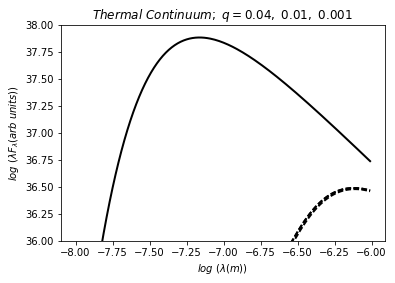

In [15]:
    #plt.ylim(36.0,38.0)
    for k in range(len(M_2nd)):
        for j in range(len(a_2nd)):
            if len(a_2nd)>1:
                ax1.plot(log_lam, flux_iter_M[k][j], color=a_color_cycle[j], ls='dashed', linewidth=2)
            else:
                ax1.plot(log_lam, flux_iter_M[k][j], color='black', ls='dashed', linewidth=2)
    ax1.plot(log_lam, log_lam_F_lam_all, color='black', ls='solid', linewidth=2)

    savefig('mcd_gap_v2.eps')
    savefig('mcd_gap_v2.png')
    show()
